<a href="https://colab.research.google.com/github/KrsNovita2717/Segmentation-Human-Silhouette-with-Unet/blob/main/Segmentation_Silhouette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library yang diperlukan

import os
import numpy as np
import cv2
import zipfile
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
from google.colab import files

In [2]:
# Ekstraksi dataset
from google.colab import drive
drive.mount('./drive')

# Ekstraksi dataset
local_zip = './drive/MyDrive/people_segmentation/people_segmentation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./people_segmentation')
zip_ref.close()

Mounted at ./drive


In [3]:
# Fungsi Blok Konvolusi
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [4]:
# Fungsi Encoder
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

In [5]:
# Fungsi Decoder
def decoder_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [6]:
# Fungsi Membangun Model U-Net
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs, name="U-Net")

In [7]:
# Fungsi Memuat dan Memproses Data

def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    # Memisahkan dataset menjadi train, validation, dan test
    train_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

    train_masks, test_masks = train_test_split(masks, test_size=0.1, random_state=42)
    train_masks, val_masks = train_test_split(train_masks, test_size=0.1, random_state=42)

    return (train_images, train_masks), (val_images, val_masks), (test_images, test_masks)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()
        x = read_image(image_path)
        y = read_mask(mask_path)
        return x, y
    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [8]:
# Hyperparameters
dataset_path = "./people_segmentation/people_segmentation"
input_shape = (256, 256, 3)
batch_size = 8
epochs = 15
lr = 1e-4

In [9]:
# Memuat dataset
(train_images, train_masks), (val_images, val_masks), (test_images, test_masks) = load_data(dataset_path)

train_dataset = tf_dataset(train_images, train_masks, batch=batch_size)
valid_dataset = tf_dataset(val_images, val_masks, batch=batch_size)
test_dataset = tf_dataset(test_images, test_masks, batch=batch_size)

In [10]:
# Membangun dan Mengkompilasi Model
model = build_unet(input_shape)

# Mendefinisikan metrik IoU
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, name='mean_iou', dtype=None, num_classes=None):
        super(MeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=lr),
    metrics=[
        MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [11]:
# Callback untuk pelatihan
model_path = "./ModelSegmentationSilhouette.h5"
model_path = "./ModelSegmentationSilhouette.keras"
csv_path = "./training.csv"
callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]

In [12]:
# Melatih Model
train_steps = len(train_images) // batch_size
if len(train_images) % batch_size != 0:
    train_steps += 1

valid_steps = len(val_images) // batch_size
if len(val_images) % batch_size != 0:
    valid_steps += 1

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/15
575/575 [==============================] - ETA: 0s - loss: 0.4002 - mean_iou: 0.3752 - recall: 0.6267 - precision: 0.6726
Epoch 1: val_loss improved from inf to 0.35177, saving model to ./ModelSegmentationSilhouette.keras
575/575 [==============================] - 418s 659ms/step - loss: 0.4002 - mean_iou: 0.3752 - recall: 0.6267 - precision: 0.6726 - val_loss: 0.3518 - val_mean_iou: 0.3718 - val_recall: 0.6052 - val_precision: 0.7483 - lr: 1.0000e-04
Epoch 2/15
575/575 [==============================] - ETA: 0s - loss: 0.3027 - mean_iou: 0.3755 - recall: 0.7189 - precision: 0.7650
Epoch 2: val_loss improved from 0.35177 to 0.29690, saving model to ./ModelSegmentationSilhouette.keras
575/575 [==============================] - 344s 599ms/step - loss: 0.3027 - mean_iou: 0.3755 - recall: 0.7189 - precision: 0.7650 - val_loss: 0.2969 - val_mean_iou: 0.3738 - val_recall: 0.6699 - val_precision: 0.8026 - lr: 1.0000e-04
Epoch 3/15
575/575 [==============================] - ETA: 0s 

In [13]:
# Evaluate the model
steps = len(test_images) // batch_size
if len(test_images) % batch_size != 0:
    steps += 1

model.evaluate(test_dataset, steps=steps)

71/71 [==============================] - 14s 200ms/step - loss: 0.1771 - mean_iou: 0.3764 - recall: 0.8701 - precision: 0.8695


[0.1770821362733841, 0.3763515055179596, 0.870147705078125, 0.8695171475410461]

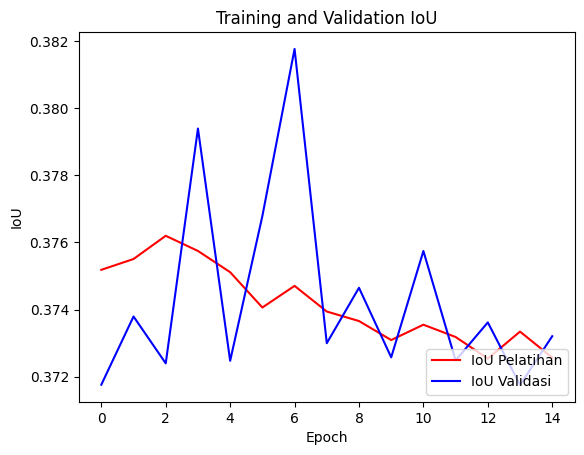

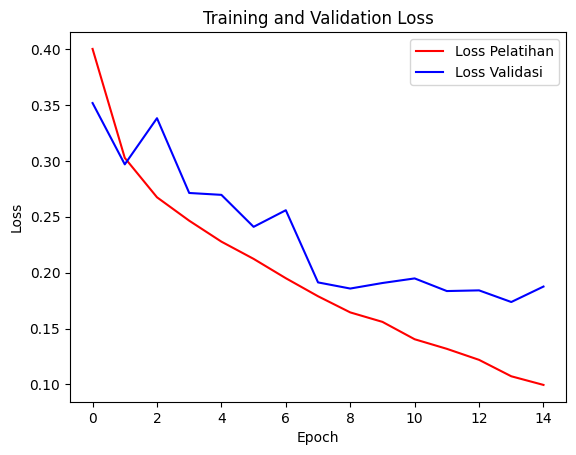

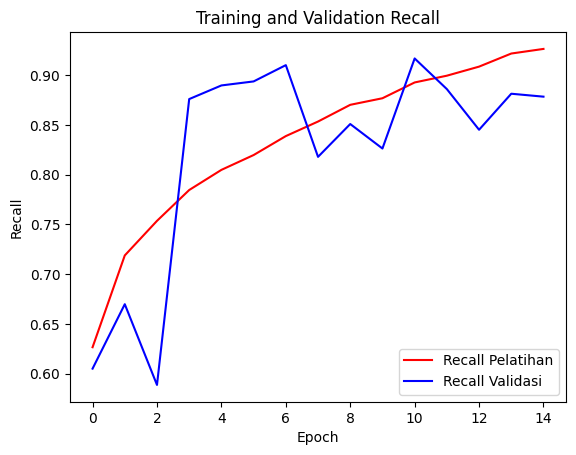

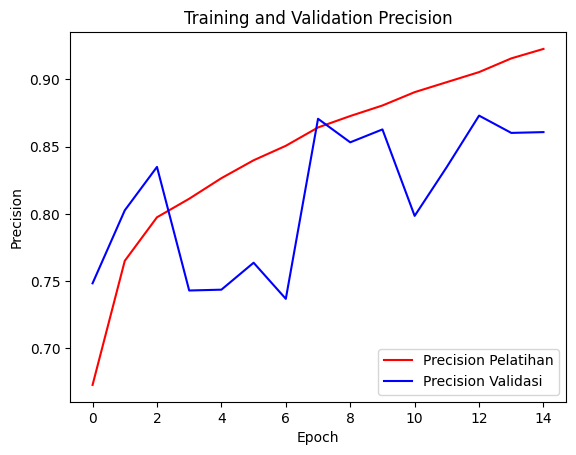

In [14]:
# Tampilkan Grafik IoU, Loss, dan Precision
plt.plot(history.history['mean_iou'], 'r', label='IoU Pelatihan')
plt.plot(history.history['val_mean_iou'], 'b', label='IoU Validasi')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title("Training and Validation IoU")
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], 'r', label='Loss Pelatihan')
plt.plot(history.history['val_loss'], 'b', label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss")
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['recall'], 'r', label='Recall Pelatihan')
plt.plot(history.history['val_recall'], 'b', label='Recall Validasi')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title("Training and Validation Recall")
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['precision'], 'r', label='Precision Pelatihan')
plt.plot(history.history['val_precision'], 'b', label='Precision Validasi')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title("Training and Validation Precision")
plt.legend(loc='lower right')
plt.show()

In [36]:
# Memuat model yang telah dilatih
trained_model = build_unet(input_shape)
trained_model.load_weights(model_path)

In [43]:
# Membuat direktori jika belum ada
os.makedirs('images/input', exist_ok=True)
os.makedirs('images/output/original_with_mask', exist_ok=True)
os.makedirs('images/output/mask', exist_ok=True)
os.makedirs('images/output/cutout', exist_ok=True)


# Fungsi untuk memproses gambar yang diunggah
def read_image_upload(image):
    img_array = np.frombuffer(image, np.uint8)
    original_image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    x_resized = cv2.resize(original_image, (256, 256))
    x_resized = x_resized / 255.0
    x_resized = x_resized.astype(np.float32)
    return original_image, x_resized

def predict_and_visualize(model, image, image_name):
    # Praproses gambar
    original_image, x = read_image_upload(image)
    x_input = np.expand_dims(x, axis=0)

    # Prediksi
    pred_mask = model.predict(x_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Mask biner
    pred_mask_bin = np.squeeze(pred_mask, axis=-1)

    # Memotong gambar dengan latar belakang hitam
    cutout = original_image.copy()
    cutout = cv2.resize(cutout, (256, 256))
    cutout[pred_mask_bin == 0] = 0

    # Membuat gambar abu-abu dengan mask
    gray_image = cv2.cvtColor((x * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    gray_image_colored = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    masked_image = np.where(np.repeat(pred_mask_bin[:, :, np.newaxis], 3, axis=2),
                            gray_image_colored,
                            (x * 255).astype(np.uint8))

    # Simpan gambar ke direktori
    original_path = os.path.join('images/input', f'{image_name}_original.jpg')
    masked_path = os.path.join('images/output/original_with_mask', f'{image_name}_original_with_mask.jpg')
    mask_path = os.path.join('images/output/mask', f'{image_name}_mask.jpg')
    cutout_path = os.path.join('images/output/cutout', f'{image_name}_cutout.jpg')

    cv2.imwrite(original_path, original_image)
    cv2.imwrite(masked_path, cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite(mask_path, pred_mask_bin * 255)
    cv2.imwrite(cutout_path, cutout)

    # Tampilkan gambar
    plt.figure(figsize=(16, 4))

    # Tampilkan gambar asli
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Tampilkan gambar dengan mask
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Mask")
    plt.axis('off')

    # Tampilkan mask yang diprediksi
    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Tampilkan hasil cutout
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB))
    plt.title("Cutout Image")
    plt.axis('off')

    plt.show()

Saving american-football-college-football-football-football-player-163505.jpg to american-football-college-football-football-football-player-163505.jpg
1/1 [==============================] - 0s 20ms/step


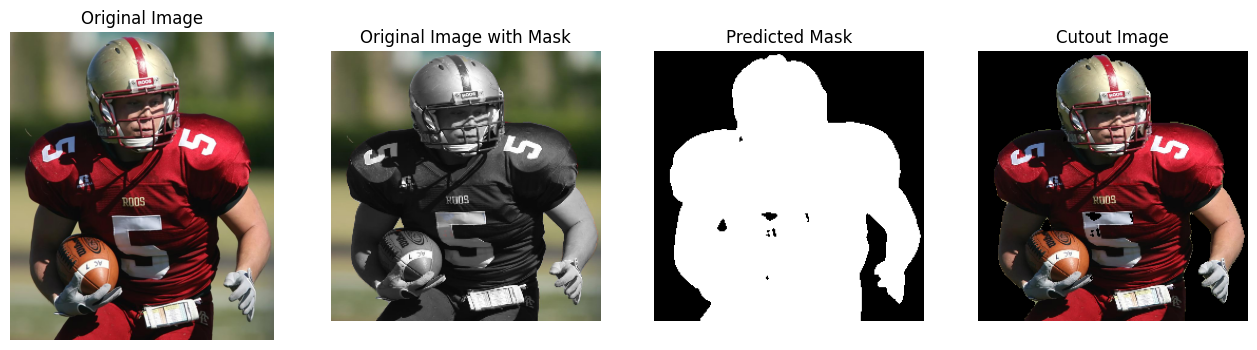

In [44]:
# Mengunggah gambar untuk pengujian
uploaded = files.upload()

# Memproses dan menampilkan hasil segmentasi
for image_name, image_data in uploaded.items():
    predict_and_visualize(trained_model, image_data, image_name)

In [45]:
# Membuat direktori jika belum ada
os.makedirs('images/input', exist_ok=True)
os.makedirs('images/output/original_with_mask', exist_ok=True)
os.makedirs('images/output/mask', exist_ok=True)
os.makedirs('images/output/cutout', exist_ok=True)

# Fungsi untuk memproses gambar yang diunggah
def read_image_upload(image):
    img_array = np.frombuffer(image, np.uint8)
    original_image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    x_resized = cv2.resize(original_image, (256, 256))
    x_resized = x_resized / 255.0
    x_resized = x_resized.astype(np.float32)
    return original_image, x_resized

def predict_and_visualize(model, image, image_name):
    # Praproses gambar
    original_image, x = read_image_upload(image)
    x_input = np.expand_dims(x, axis=0)

    # Prediksi
    pred_mask = model.predict(x_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Mask biner
    pred_mask_bin = np.squeeze(pred_mask, axis=-1)

    # Memotong gambar dengan latar belakang hitam
    cutout = original_image.copy()
    cutout = cv2.resize(cutout, (256, 256))
    cutout[pred_mask_bin == 0] = 0

    # Membuat gambar abu-abu dengan mask
    gray_image = cv2.cvtColor((x * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    gray_image_colored = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    masked_image = np.where(np.repeat(pred_mask_bin[:, :, np.newaxis], 3, axis=2),
                            (x * 255).astype(np.uint8),
                            gray_image_colored)

    # Simpan gambar ke direktori
    original_path = os.path.join('images/input', f'{image_name}_original.jpg')
    masked_path = os.path.join('images/output/original_with_mask', f'{image_name}_original_with_mask.jpg')
    mask_path = os.path.join('images/output/mask', f'{image_name}_mask.jpg')
    cutout_path = os.path.join('images/output/cutout', f'{image_name}_cutout.jpg')

    cv2.imwrite(original_path, original_image)
    cv2.imwrite(masked_path, cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite(mask_path, pred_mask_bin * 255)  # Konversi mask ke skala 0-255
    cv2.imwrite(cutout_path, cutout)

    # Tampilkan gambar
    plt.figure(figsize=(16, 4))

    # Tampilkan gambar asli
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Tampilkan gambar dengan mask
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Mask")
    plt.axis('off')

    # Tampilkan mask yang diprediksi
    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Tampilkan hasil cutout
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB))
    plt.title("Cutout Image")
    plt.axis('off')

    plt.show()


Saving american-football-college-football-football-football-player-163505.jpg to american-football-college-football-football-football-player-163505 (1).jpg
1/1 [==============================] - 0s 75ms/step


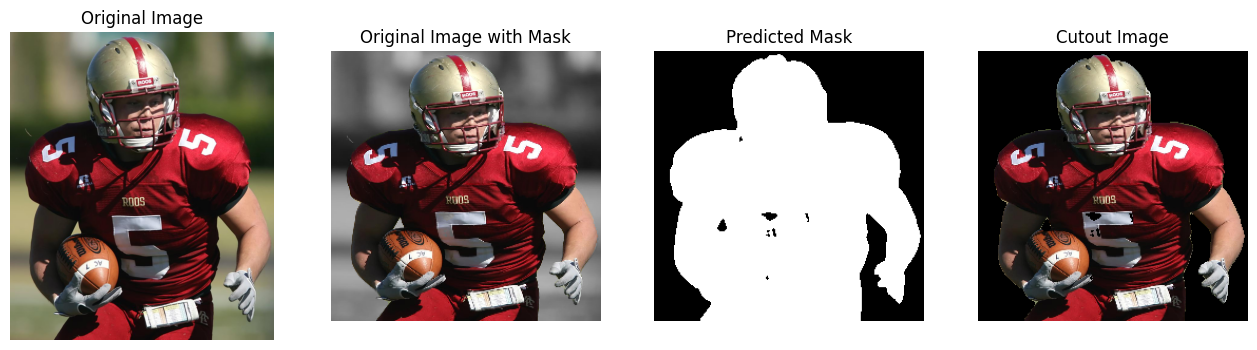

In [46]:
# Mengunggah gambar untuk pengujian
uploaded = files.upload()

# Memproses dan menampilkan hasil segmentasi
for image_name, image_data in uploaded.items():
    predict_and_visualize(trained_model, image_data, image_name)